In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [140]:
training_data = pd.read_csv('data/baotou-training.csv')
training_data.date = pd.to_datetime(training_data.date)
training_data.columns = ['date','PM25','PM10','O3','NO2','SO2','CO']

training_data.replace('Missing value', pd.NA, inplace=True)

training_data['date'] = pd.to_datetime(training_data['date'])

for col in training_data.columns:
    if col != "date":
        training_data[col] = pd.to_numeric(training_data[col], errors='coerce')

training_data = training_data.dropna()

training_data = training_data.sort_values('date', ascending=True)

training_data

/var/folders/n0/qhjx1vrd1c1b846x7pqgmbg40000gn/T/ipykernel_95871/1484779605.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  training_data.date = pd.to_datetime(training_data.date)


,date,PM25,PM10,O3,NO2,SO2,CO
3482,2015-05-18,141.0,90.0,53.0,12.0,13.0,10.0
3483,2015-05-19,98.0,44.0,48.0,7.0,6.0,7.0
3484,2015-05-20,74.0,58.0,57.0,20.0,15.0,24.0
3485,2015-05-21,87.0,118.0,71.0,22.0,24.0,17.0
3486,2015-05-22,123.0,150.0,86.0,35.0,29.0,19.0
...,...,...,...,...,...,...,...
398,2023-11-05,138.0,69.0,27.0,10.0,7.0,7.0
399,2023-11-06,97.0,42.0,26.0,12.0,8.0,7.0
400,2023-11-07,59.0,67.0,26.0,23.0,15.0,10.0
401,2023-11-08,111.0,54.0,31.0,11.0,8.0,6.0


<class 'numpy.ndarray'>


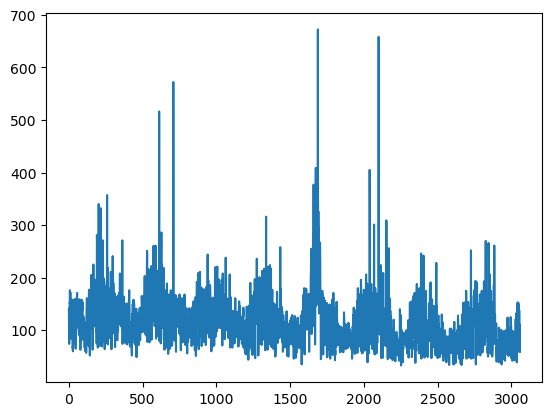

In [141]:
training_data = training_data.iloc[:, 1].values
print(type(training_data))
plt.plot(training_data)

In [142]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data.reshape(-1, 1))


In [143]:
x_training_data = []
y_training_data =[]
for i in range(700, len(training_data)):
    x_training_data.append(training_data[i-700:i, 0])
    y_training_data.append(training_data[i, 0])

In [144]:
x_training_data = np.array(x_training_data)
y_training_data = np.array(y_training_data)

In [145]:
print(x_training_data.shape)
print(y_training_data.shape)

(2358, 700)
(2358,)


In [146]:
x_training_data = np.reshape(x_training_data, (x_training_data.shape[0],
                                               x_training_data.shape[1],
                                               1))

In [147]:
print(x_training_data.shape)

(2358, 700, 1)


In [148]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [149]:
rnn = Sequential()

In [150]:
rnn.add(LSTM(units = 64, return_sequences = True, input_shape = (x_training_data.shape[1], 1)))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [151]:
rnn.add(Dropout(0.2))

In [152]:
rnn.add(LSTM(units = 64, return_sequences = True))
rnn.add(Dropout(0.2))
rnn.add(LSTM(units = 64, return_sequences = True))
rnn.add(Dropout(0.2))
rnn.add(LSTM(units = 64))
rnn.add(Dropout(0.2))

In [153]:
rnn.add(Dense(units = 1))

In [154]:
rnn.compile(optimizer = 'adam', loss = 'mae')

In [155]:
# -----

In [156]:
from sklearn.model_selection import train_test_split

split_ratio = 0.9
split_index = int(len(x_training_data) * split_ratio)

x_train = x_training_data[:split_index]
y_train = y_training_data[:split_index]
x_val = x_training_data[split_index:]
y_val = y_training_data[split_index:]

In [157]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    min_delta=0.000001
)

In [158]:
rnn.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=45,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/45
67/67 ━━━━━━━━━━━━━━━━━━━━ 44s 630ms/step - loss: 0.0597 - val_loss: 0.0407
Epoch 2/45
67/67 ━━━━━━━━━━━━━━━━━━━━ 40s 601ms/step - loss: 0.0503 - val_loss: 0.0390
Epoch 3/45
67/67 ━━━━━━━━━━━━━━━━━━━━ 39s 584ms/step - loss: 0.0484 - val_loss: 0.0478
Epoch 4/45
67/67 ━━━━━━━━━━━━━━━━━━━━ 40s 592ms/step - loss: 0.0485 - val_loss: 0.0402
Epoch 5/45
67/67 ━━━━━━━━━━━━━━━━━━━━ 39s 578ms/step - loss: 0.0504 - val_loss: 0.0403
Epoch 6/45
67/67 ━━━━━━━━━━━━━━━━━━━━ 39s 586ms/step - loss: 0.0487 - val_loss: 0.0406
Epoch 7/45
67/67 ━━━━━━━━━━━━━━━━━━━━ 39s 584ms/step - loss: 0.0499 - val_loss: 0.0422
Epoch 8/45
67/67 ━━━━━━━━━━━━━━━━━━━━ 39s 588ms/step - loss: 0.0489 - val_loss: 0.0402
Epoch 9/45
67/67 ━━━━━━━━━━━━━━━━━━━━ 39s 578ms/step - loss: 0.0498 - val_loss: 0.0400
Epoch 10/45
67/67 ━━━━━━━━━━━━━━━━━━━━ 40s 591ms/step - loss: 0.0482 - val_loss: 0.0381
Epoch 11/45
67/67 ━━━━━━━━━━━━━━━━━━━━ 38s 574ms/step - loss: 0.0482 - val_loss: 0.0379
Epoch 12/45
67/67 ━━━━━━━━━━━━━━━━━━━━ 39

In [159]:
rnn.save('pm25_lstm_model.keras')

In [160]:
test_data = pd.read_csv('data/baotou-testing.csv')
test_data.date = pd.to_datetime(test_data.date)
test_data.columns = ['date','PM25','PM10','O3','NO2','SO2','CO']

test_data['date'] = pd.to_datetime(test_data['date'])

for col in test_data.columns:
    if col != "date":
        test_data[col] = pd.to_numeric(test_data[col], errors='coerce')

test_data = test_data.sort_values('date', ascending=True)

test_data

/var/folders/n0/qhjx1vrd1c1b846x7pqgmbg40000gn/T/ipykernel_95871/41312521.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test_data.date = pd.to_datetime(test_data.date)


,date,PM25,PM10,O3,NO2,SO2,CO
100,2025-01-02,129,40.0,NaN,17.0,9.0,7.0
101,2025-01-03,65,59.0,NaN,29.0,16.0,17.0
102,2025-01-04,103,84.0,NaN,27.0,13.0,17.0
103,2025-01-05,119,77.0,NaN,13.0,7.0,7.0
104,2025-01-06,81,43.0,NaN,20.0,10.0,11.0
...,...,...,...,...,...,...,...
4,2025-07-06,29,23.0,NaN,13.0,3.0,4.0
5,2025-07-07,44,20.0,NaN,11.0,3.0,5.0
6,2025-07-08,51,26.0,NaN,10.0,5.0,7.0
7,2025-07-09,73,23.0,NaN,6.0,4.0,7.0


(190,)


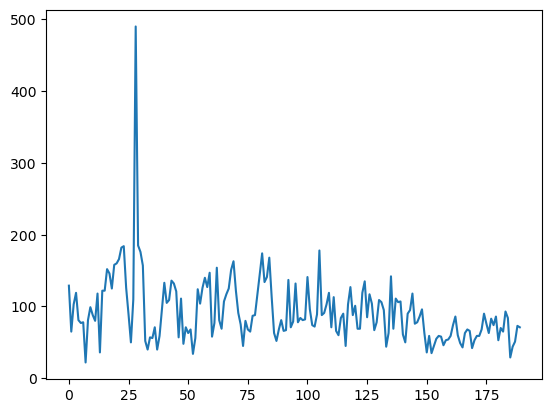

In [161]:
test_data = test_data.iloc[:,1].values
print(test_data.shape)
plt.plot(test_data);

In [162]:
unscaled_testing_data = pd.read_csv('data/baotou-testing.csv')
unscaled_testing_data.date = pd.to_datetime(unscaled_testing_data.date)
unscaled_testing_data.columns = ['date','PM25','PM10','O3','NO2','SO2','CO']

unscaled_testing_data.replace('Missing value', pd.NA, inplace=True)

unscaled_testing_data['date'] = pd.to_datetime(unscaled_testing_data['date'])

for col in unscaled_testing_data.columns:
    if col != "date":
        unscaled_testing_data[col] = pd.to_numeric(unscaled_testing_data[col], errors='coerce')

unscaled_testing_data = unscaled_testing_data.dropna()

unscaled_testing_data = unscaled_testing_data.sort_values('date', ascending=True)

/var/folders/n0/qhjx1vrd1c1b846x7pqgmbg40000gn/T/ipykernel_95871/3006983199.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  unscaled_testing_data.date = pd.to_datetime(unscaled_testing_data.date)


In [163]:
def read_and_clean(filepath):
    df = pd.read_csv(filepath)
    df.date = pd.to_datetime(df.date)
    df.columns = ['date','PM25','PM10','O3','NO2','SO2','CO']

    df.replace('Missing value', pd.NA, inplace=True)

    df['date'] = pd.to_datetime(df['date'])

    for col in df.columns:
        if col != "date":
            df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df.sort_values('date', ascending=True)

    return df

unscaled_training_data = read_and_clean('data/baotou-training.csv').dropna()
unscaled_test_data = read_and_clean('data/baotou-testing.csv')

/var/folders/n0/qhjx1vrd1c1b846x7pqgmbg40000gn/T/ipykernel_95871/195247760.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.date = pd.to_datetime(df.date)
/var/folders/n0/qhjx1vrd1c1b846x7pqgmbg40000gn/T/ipykernel_95871/195247760.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.date = pd.to_datetime(df.date)


In [164]:
unscaled_training_data.tail()

,date,PM25,PM10,O3,NO2,SO2,CO
398,2023-11-05,138.0,69.0,27.0,10.0,7.0,7.0
399,2023-11-06,97.0,42.0,26.0,12.0,8.0,7.0
400,2023-11-07,59.0,67.0,26.0,23.0,15.0,10.0
401,2023-11-08,111.0,54.0,31.0,11.0,8.0,6.0
402,2023-11-09,59.0,18.0,29.0,9.0,4.0,4.0


In [165]:
unscaled_test_data.tail()

,date,PM25,PM10,O3,NO2,SO2,CO
4,2025-07-06,29,23.0,NaN,13.0,3.0,4.0
5,2025-07-07,44,20.0,NaN,11.0,3.0,5.0
6,2025-07-08,51,26.0,NaN,10.0,5.0,7.0
7,2025-07-09,73,23.0,NaN,6.0,4.0,7.0
8,2025-07-10,71,NaN,NaN,NaN,NaN,NaN


In [166]:
all_data = pd.concat((unscaled_training_data['PM25'], unscaled_test_data['PM25']), axis = 0)
x_test_data = all_data[len(all_data) - len(test_data) - 700:].values
x_test_data = np.reshape(x_test_data, (-1, 1))

In [167]:
x_test_data = scaler.transform(x_test_data)
final_x_test_data = []
for i in range(700, len(x_test_data)):
    final_x_test_data.append(x_test_data[i-700:i, 0])
final_x_test_data = np.array(final_x_test_data)
final_x_test_data = np.reshape(final_x_test_data, (final_x_test_data.shape[0],
                                                   final_x_test_data.shape[1],
                                                   1))

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step


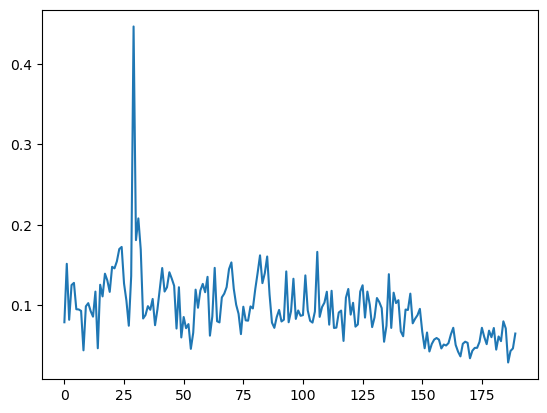

In [168]:
predictions = rnn.predict(final_x_test_data)
plt.clf()
plt.plot(predictions)

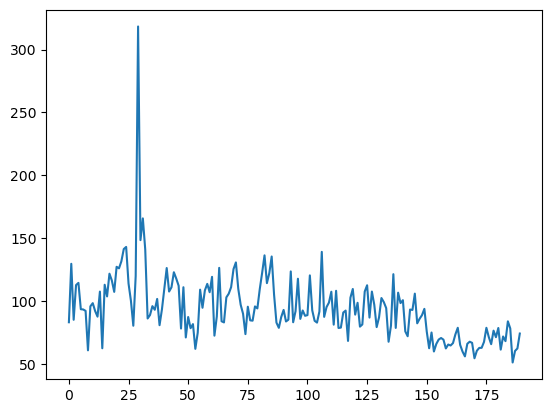

In [169]:
unscaled_predictions = scaler.inverse_transform(predictions)
plt.clf() #This clears the first prediction plot from our canvas
plt.plot(unscaled_predictions)

Text(0.5, 1.0, 'baotou pm2.5 level')

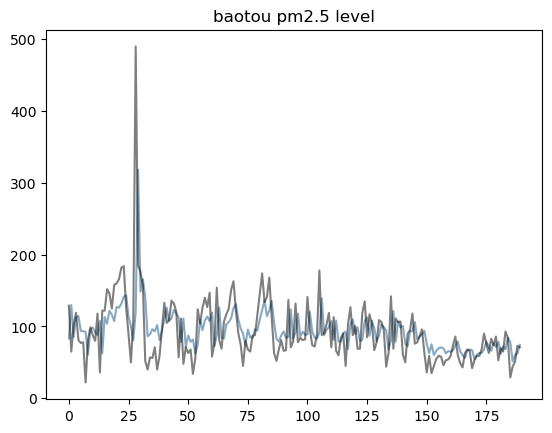

In [176]:
plt.plot(unscaled_predictions, color = '#135485', label = "Predictions", alpha=0.5)
plt.plot(test_data, color = 'black', label = "Real Data", alpha=0.5)
plt.title('baotou pm2.5 level')

In [171]:
# ---------

In [172]:
combined_data = pd.concat((unscaled_training_data['PM25'], unscaled_test_data['PM25']), axis=0)
last_700_values = combined_data[-700:].values.reshape(-1,1)
last_700_scaled = scaler.transform(last_700_values)

In [173]:
future_predictions = []

current_input = last_700_scaled.copy()

In [174]:
for _ in range(365):
    input_seq = current_input.reshape(1,700,1)
    predicted_scaled = rnn.predict(input_seq,verbose=0)[0,0]
    future_predictions.append(predicted_scaled)
    current_input = np.append(current_input, [[predicted_scaled]], axis=0)
    current_input = current_input[-700:]

future_predictions_unscaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))

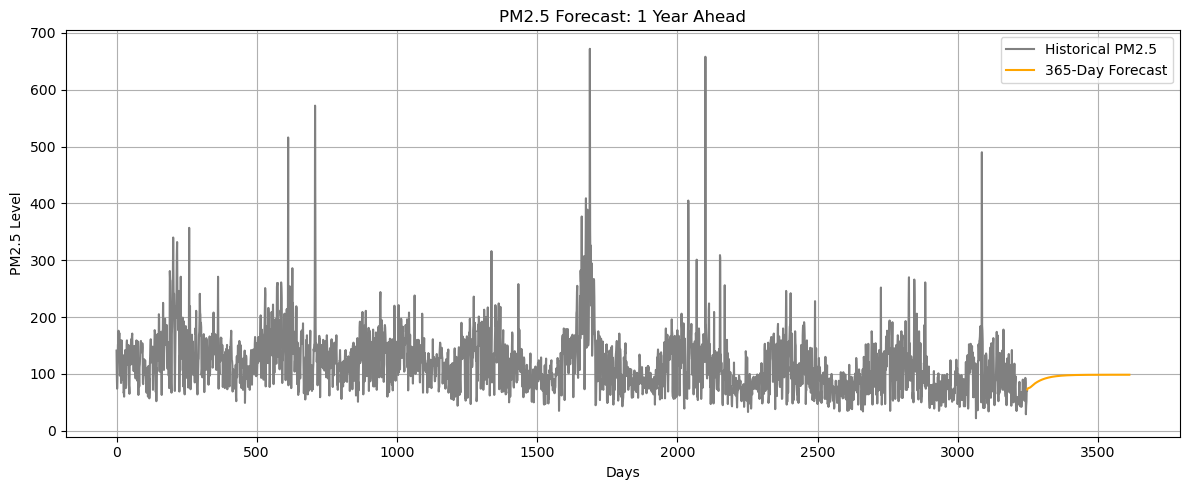

In [175]:
plt.figure(figsize=(12,5))
plt.plot(combined_data.values, label='Historical PM2.5', color='gray')
plt.plot(range(len(combined_data), len(combined_data)+365),
         future_predictions_unscaled.flatten(),
         label='365-Day Forecast', color='orange')
plt.title("PM2.5 Forecast: 1 Year Ahead")
plt.xlabel("Days")
plt.ylabel("PM2.5 Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()